In [12]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [13]:
# Import data here
df=pd.read_csv("../datasets/FullDataset.csv", header=None)
df.head()

,0,1,2,3,4,5,6
0,Residual_Power,Application_Type,Min_Security_Level,Max_Stack_Usage,Max_ROM,Min_Throughput,Algorithm
1,100,A,Low,300,17,10,Xoodyak
2,90,A,Low,300,17,10,Xoodyak
3,80,A,Low,300,17,10,Xoodyak
4,70,A,Low,300,17,10,Xoodyak


In [14]:
df.columns = df.iloc[0]
df = df[1:]
df.head()

,Residual_Power,Application_Type,Min_Security_Level,Max_Stack_Usage,Max_ROM,Min_Throughput,Algorithm
1,100,A,Low,300,17,10,Xoodyak
2,90,A,Low,300,17,10,Xoodyak
3,80,A,Low,300,17,10,Xoodyak
4,70,A,Low,300,17,10,Xoodyak
5,60,A,Low,300,17,10,Xoodyak


In [15]:
df['Residual_Power'] = pd.to_numeric(df['Residual_Power'])
df['Max_Stack_Usage'] = pd.to_numeric(df['Max_Stack_Usage'])
df['Max_ROM'] = pd.to_numeric(df['Max_ROM'])
df['Min_Throughput'] = pd.to_numeric(df['Min_Throughput'])
df.dtypes

0
Residual_Power         int64
Application_Type      object
Min_Security_Level    object
Max_Stack_Usage        int64
Max_ROM                int64
Min_Throughput         int64
Algorithm             object
dtype: object

In [16]:
# Feature selection
X = df.drop(['Algorithm'], axis=1)
y = df['Algorithm']

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))
low_cardinality_cols

['Min_Security_Level']

In [18]:
num_X_train = X_train.select_dtypes(exclude=['object'])
num_X_test = X_test.select_dtypes(exclude=['object'])

OH_cols_train = pd.get_dummies(X_train[low_cardinality_cols],drop_first=False)
OH_cols_test = pd.get_dummies(X_test[low_cardinality_cols],drop_first=False)

X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

In [19]:
model = CategoricalNB()
model.fit(X_train, y_train)

CategoricalNB()

In [20]:
y_predict = model.predict(X_test)

In [21]:
# Accuracy
print("Accuracy of Naive Bayes model is ", metrics.accuracy_score(y_test, y_predict))
print("F1 Score is ", metrics.f1_score(y_predict, y_test, average="weighted"))

Accuracy of Naive Bayes model is  0.5555555555555556
F1 Score is  0.6727478303385893


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (10).

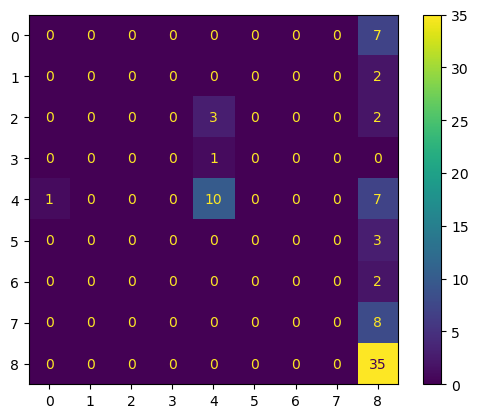

In [22]:
# Confusion matrix
# labels = ["cipher1", "cipher2", ...]
cm = metrics.confusion_matrix(y_test, y_predict)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot(xticks_rotation='vertical')

In [ ]:
# ROC curve
from sklearn.preprocessing import label_binarize
import numpy as np

y_scores = model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=np.unique(y))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:, i], y_scores[:, 1])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

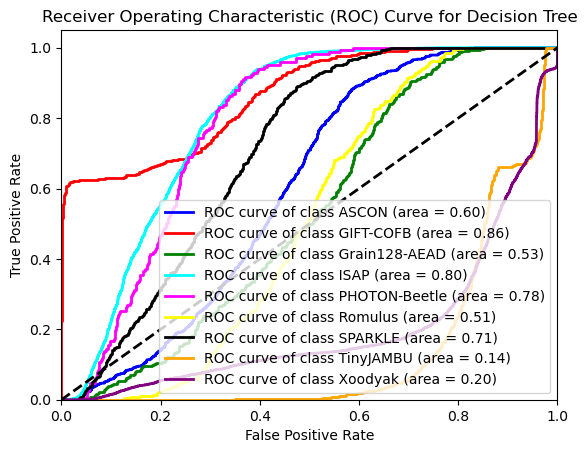

In [ ]:
# Plot the ROC curve for each class

import matplotlib.pyplot as plt
plt.figure()
classes = model.classes_
colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple']
for i, cur_class, color in zip(range(n_classes), classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(cur_class, roc_auc[i]))

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for Decision Tree")
plt.legend(loc="lower right")
plt.show()

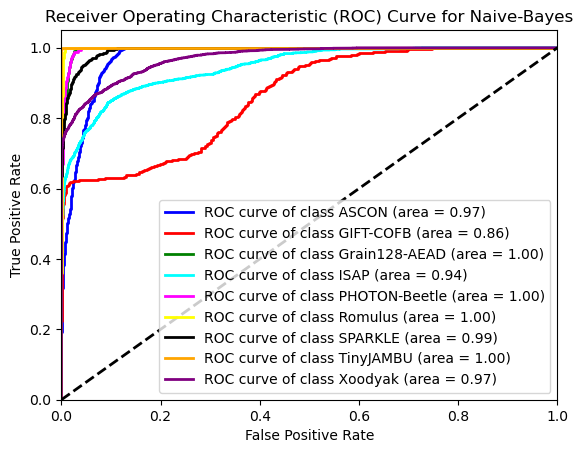

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_scores = model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=np.unique(y))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
classes = model.classes_
colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple']
for i, cur_class, color in zip(range(n_classes), classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(cur_class, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive-Bayes')
plt.legend(loc="lower right")
plt.show()